# Midterm submission - WiDS2025 Predicting Stock Volatility Using Financial News Sentiment Analysis

In [13]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import matplotlib.pyplot as plt

## Task 1: Multi-source Financial News Collection

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

rss_feeds = {
    "MarketWatch": "https://feeds.marketwatch.com/marketwatch/topstories",
    "Yahoo Finance": "https://finance.yahoo.com/rss/topstories"
}

rss_feeds = {
    "Yahoo Finance": "https://finance.yahoo.com/rss/topstories",
    "MarketWatch": "https://feeds.marketwatch.com/marketwatch/topstories",
    "CNBC": "https://www.cnbc.com/id/100003114/device/rss/rss.html"
}

news_data = []

for source, url in rss_feeds.items():
    try:
        response = requests.get(url, timeout=10)
        soup = BeautifulSoup(response.content, "xml")
        
        for item in soup.find_all("item"):
            news_data.append({
                "source": source,
                "headline": item.title.text if item.title else None,
                "pubDate": item.pubDate.text if item.pubDate else None
            })
    except Exception as e:
        print(f"Failed to fetch {source}: {e}")

news_df = pd.DataFrame(news_data)
news_df.head()


,source,headline,pubDate
0,MarketWatch,‘I’m on a fixed budget’: Silver and gold are n...,"Thu, 01 Jan 2026 13:30:00 GMT"
1,MarketWatch,‘We never want to think our children would str...,"Thu, 01 Jan 2026 13:00:00 GMT"
2,MarketWatch,‘He has become hostile’: My mom is in her 80s ...,"Thu, 01 Jan 2026 12:00:00 GMT"
3,MarketWatch,20 stocks in the S&P 500 that gained the most ...,"Thu, 01 Jan 2026 11:29:00 GMT"
4,MarketWatch,I’m afraid my financial adviser will steal my ...,"Thu, 01 Jan 2026 10:45:00 GMT"


In [3]:
news_df.to_csv("news_raw.csv", index=False)


## Task 2:XML Structure Understanding
1. Headlines were extracted using the `<title>` tag in the RSS XML feed.

2. The `<item>` tag represents a single news article and contains details such as the headline and publication date.

3. RSS XML feeds are structured for machine readability and automated data extraction, while HTML webpages are designed mainly for human viewing and visual presentation.


## Task 3: News Data Cleaning and Standardization

In [4]:
news_cleaned = news_df.copy()

news_cleaned["pubDate"] = pd.to_datetime(news_cleaned["pubDate"], utc=True)

news_cleaned["date"] = news_cleaned["pubDate"].dt.date

news_cleaned["headline_length"] = news_cleaned["headline"].str.len()

news_cleaned.head()


,source,headline,pubDate,date,headline_length
0,MarketWatch,‘I’m on a fixed budget’: Silver and gold are n...,2026-01-01 13:30:00+00:00,2026-01-01,116
1,MarketWatch,‘We never want to think our children would str...,2026-01-01 13:00:00+00:00,2026-01-01,124
2,MarketWatch,‘He has become hostile’: My mom is in her 80s ...,2026-01-01 12:00:00+00:00,2026-01-01,94
3,MarketWatch,20 stocks in the S&P 500 that gained the most ...,2026-01-01 11:29:00+00:00,2026-01-01,53
4,MarketWatch,I’m afraid my financial adviser will steal my ...,2026-01-01 10:45:00+00:00,2026-01-01,108


In [5]:
news_cleaned.to_csv("news_cleaned.csv", index=False)


## Task 4: Stock Price Data Collection

In [6]:
import yfinance as yf
import pandas as pd

ticker = yf.Ticker("NVDA")
stock_df = ticker.history(period="15d")

stock_df = stock_df[["Open", "High", "Low", "Close", "Volume"]]
stock_df = stock_df.reset_index()
stock_df["date"] = stock_df["Date"].dt.date
stock_df = stock_df.drop(columns=["Date"])

stock_df.head()


,Open,High,Low,Close,Volume,date
0,184.970001,185.479996,182.039993,183.779999,162785400,2025-12-10
1,180.279999,181.320007,176.619995,180.929993,182136600,2025-12-11
2,181.110001,182.820007,174.619995,175.020004,204274900,2025-12-12
3,177.940002,178.419998,175.029999,176.289993,164775600,2025-12-15
4,176.259995,178.490005,174.899994,177.720001,148588100,2025-12-16


In [7]:
stock_df.to_csv("stock_data.csv", index=False)


## Task 5: Market Calendar Awareness
1. The non-trading date identified in the dataset is **2026-01-01**, which appears in the news data but does not appear in the stock price data.

2. The stock market does not trade on this date because **January 1st is New Year’s Day**, a public holiday on which US stock exchanges are officially closed.

3. A total of **3 news articles** fall on this non-trading day, indicating that financial news continues to be published even when markets are closed.


## Task 6: Intelligent Data Merging

In [8]:
merged_df = news_cleaned.merge(
    stock_df,
    on="date",
    how="left"
)

merged_df["is_trading_day"] = merged_df["Open"].notna()

merged_df.head()


,source,headline,pubDate,date,headline_length,Open,High,Low,Close,Volume,is_trading_day
0,MarketWatch,‘I’m on a fixed budget’: Silver and gold are n...,2026-01-01 13:30:00+00:00,2026-01-01,116,NaN,NaN,NaN,NaN,NaN,False
1,MarketWatch,‘We never want to think our children would str...,2026-01-01 13:00:00+00:00,2026-01-01,124,NaN,NaN,NaN,NaN,NaN,False
2,MarketWatch,‘He has become hostile’: My mom is in her 80s ...,2026-01-01 12:00:00+00:00,2026-01-01,94,NaN,NaN,NaN,NaN,NaN,False
3,MarketWatch,20 stocks in the S&P 500 that gained the most ...,2026-01-01 11:29:00+00:00,2026-01-01,53,NaN,NaN,NaN,NaN,NaN,False
4,MarketWatch,I’m afraid my financial adviser will steal my ...,2026-01-01 10:45:00+00:00,2026-01-01,108,NaN,NaN,NaN,NaN,NaN,False


In [9]:
merged_df.to_csv("merged_midterm_data.csv", index=False)


## Task 7: Exploratory Analysis

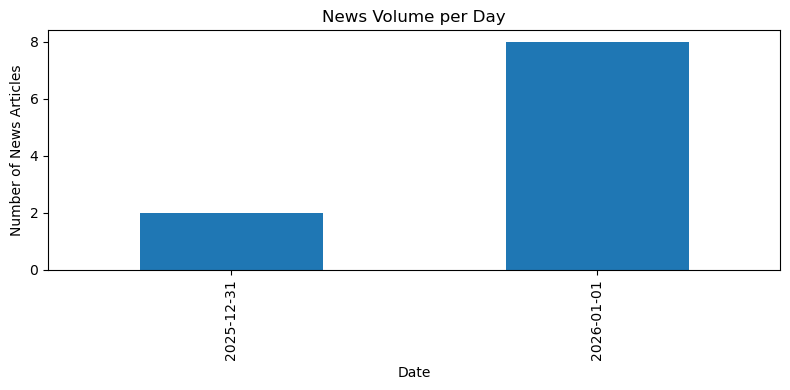

In [10]:
news_per_day = merged_df.groupby("date").size()

news_per_day.plot(kind="bar", figsize=(8,4), title="News Volume per Day")
plt.xlabel("Date")
plt.ylabel("Number of News Articles")
plt.tight_layout()
plt.show()


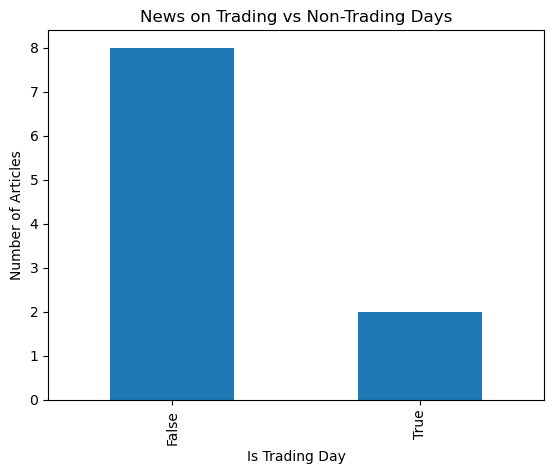

In [11]:
merged_df["is_trading_day"].value_counts().plot(
    kind="bar",
    title="News on Trading vs Non-Trading Days"
)
plt.xlabel("Is Trading Day")
plt.ylabel("Number of Articles")
plt.show()


In [12]:
## Multiple news articles are published on the same day
merged_df.groupby("date").size()


date
2025-12-31    2
2026-01-01    8
dtype: int64

#### Multiple news articles are frequently published on the same day, suggesting that important financial events and market discussions tend to occur in clusters rather than being spread evenly over time.